In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision
import torch.optim.lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

In [2]:
BATCH_SIZE = 20
EPOCH = 50
GAMMA = 0.9
STEP_SIZE = 200
LR = 0.0001
USE_GPU = True
decoder = ['buoy', 'dock', 'light_buoy', 'totem']
data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
img_path = '/home/arg_ws3/david_trainings/image_data'
model_path = './model_scale'

In [3]:
alexnet = torchvision.models.alexnet(pretrained = True)
alexnet.classifier[6] = nn.Linear(4096, 4)
if USE_GPU:
    alexnet = alexnet.cuda()
#optimizer = torch.optim.Adam(alexnet.parameters(), lr=LR)   # optimize all cnn parameters
optimizer = torch.optim.SGD(alexnet.parameters(), lr = LR, momentum=0.9)
loss_func = nn.CrossEntropyLoss() # the target label is not one-hotted
if USE_GPU:
    loss_func = loss_func.cuda()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [4]:
class MultiViewNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiViewNet, self).__init__()
        # Everything except the last linear layer
        self.base_features = base_model.features
        self.base_classifier = nn.Sequential(*base_model.classifier[:-1])
        self.new_classifier = nn.Sequential(
            nn.Linear(4099, num_classes)
        )
        self.modelName = 'MultiViewNet'
        
        '''
        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False
        '''

    def forward(self, img, scale):
        f = self.base_features(img)
        f = f.view(f.size(0), -1)
        fc2 = self.base_classifier(f)
        fc2_cat = torch.cat((scale[0], scale[1], scale[2], fc2), dim=1)
        y = self.new_classifier(fc2_cat)
        return y

base_model = torchvision.models.alexnet(pretrained = True)
multiviewnet = MultiViewNet(base_model, 4)
if USE_GPU:
    multiviewnet = multiviewnet.cuda()
#for p in multiviewnet.base_features[0].parameters():
#    print(p.name, p.data)
#optimizer = torch.optim.Adam(alexnet.parameters(), lr=LR)   # optimize all cnn parameters
optimizer = torch.optim.SGD(multiviewnet.parameters(), lr = LR, momentum=0.9)
loss_func = nn.CrossEntropyLoss() # the target label is not one-hotted
if USE_GPU:
    loss_func = loss_func.cuda()
print(multiviewnet)

MultiViewNet(
  (base_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (base_classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=40

In [5]:
class MultiViewDataset(torch.utils.data.Dataset):
    def __init__(self, root = '../images', transform = None):
        self.root = root
        self.transform = transform
        self.imgData = datasets.ImageFolder(root = self.root, \
                                transform = self.transform)
        self.classes = self.imgData.classes
        self.class_to_idx = self.imgData.class_to_idx
        
    def __len__(self):
        return self.imgData.__len__()

    def __getitem__(self, idx):
        img = self.imgData.__getitem__(idx)[0]
        label = self.imgData.__getitem__(idx)[1]
        return img, label

In [14]:
class MultiViewScaleDataset(torch.utils.data.Dataset):
    def __init__(self, root = '../images', transform = None):
        self.root = root
        self.transform = transform
        self.imgData = datasets.ImageFolder(root = self.root, \
                                transform = self.transform)
        self.classes = self.imgData.classes
        self.class_to_idx = self.imgData.class_to_idx
        
    def __len__(self):
        return self.imgData.__len__()

    def __getitem__(self, idx):
        img = self.imgData.__getitem__(idx)[0]
        label = self.imgData.__getitem__(idx)[1]
        img_name = self.imgData.samples[idx][0]
        s = img_name.split('.jpg')
        s = s[0].split('/')
        scalar_nums = s[-1].split('_')[-3:]
        scalar_nums = [torch.FloatTensor([math.log(float(i))*2]) for i in scalar_nums]
        if len(scalar_nums)!=3:
            return img, label, ['0', '0', '0']
        return img, label, scalar_nums

In [15]:
'''class MultiViewDataset(torch.utils.data.Dataset):
    def __init__(self, root = '../images', transform = None, extensions = ['.jpg']):
        classes, class_to_idx = self.find_classes(root)
        samples = make_dataset(root, class_to_idx, IMG_EXTENSIONS)
        self.root = root
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples

    def has_file_allowed_extension(self, filename, extensions):
        """Checks if a file is an allowed extension.
        Args:
            filename (string): path to a file
            extensions (iterable of strings): extensions to consider (lowercase)
        Returns:
            bool: True if the filename ends with one of given extensions
        """
        filename_lower = filename.lower()
        return any(filename_lower.endswith(ext) for ext in extensions)
    
    def make_dataset(self, dir, class_to_idx, extensions):
        images = []
        dir = os.path.expanduser(dir)
        for target in sorted(class_to_idx.keys()):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue

            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    if self.has_file_allowed_extension(fname, extensions):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target])
                        images.append(item)
        return images
        
    def find_classes(self, dir):
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        return path, target'''
print('skip')

skip


# Loading data

### Use torch ImageFolder

In [16]:
'''train_data = datasets.ImageFolder(root = img_path, \
                                transform = data_transform)'''

'''train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                batch_size = BATCH_SIZE, \
                                shuffle = True)'''

'train_loader = torch.utils.data.DataLoader(dataset = train_data,                                 batch_size = BATCH_SIZE,                                 shuffle = True)'

### Use custom dataset

In [17]:
MultiViewDst = MultiViewScaleDataset(root = img_path,\
                            transform = data_transform)
decoder = MultiViewDst.classes
print(decoder)

['buoy', 'dock', 'light_buoy', 'totem']


### Splitting dataset to training & validation set

In [18]:
dataset_size = len(MultiViewDst) #3080 #2080
indices = list(range(dataset_size))
validation_split = .1
split = int(np.floor(validation_split * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = BATCH_SIZE, \
                                sampler = train_sampler)
validation_size = len(val_indices)
validation_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = validation_size, \
                                sampler = valid_sampler)
valid_iter = iter(validation_loader)
valid_data = next(valid_iter)
valid_y = valid_data[1].cuda()

In [19]:
def compute_accuracy_scale(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
        scale = [x.cuda() for x in validset[2]]
    output = model(validset[0], scale)
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

In [20]:
def compute_accuracy(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
    output = model(validset[0])
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

In [21]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
count = 0
loss_values = []
lr = LR
for epoch in range(EPOCH):
    for step, (b_x, b_y, b_scale) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        if USE_GPU:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            b_scale = [x.cuda() for x in b_scale]
        #print(b_x.shape)
        output = multiviewnet(b_x, b_scale)  # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        #loss_values.append(loss.item())
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        #scheduler.step()                # dynamic learning rate
        
        if count % STEP_SIZE == 0 and count != 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= GAMMA
                lr = param_group['lr']
        
        if step % 100 == 0:
            accuracy = compute_accuracy_scale(multiviewnet, valid_data, valid_y)
            print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), \
                  '| accuracy: %.4f' % accuracy, \
                  '| learning rate: %.6f' % lr)
        if count % 10 == 0 and count != 0:
            loss_values.append(loss.item())
        if count % 200 == 0 and count != 0:
            plt.plot(loss_values, '-b', label='loss')
            plt.show()
        count = count + 1
    if epoch % 5 == 0 and epoch != 0:
        PATH = model_path + '/robotx_ch3_epoch' + str(epoch) + '.pth'
        torch.save(multiviewnet.state_dict(), PATH)
        print("Save net: ", PATH)
print("Finish")

Epoch:  0 | train loss: 42.860512 | accuracy: 0.2816 | learning rate: 0.000100
Epoch:  1 | train loss: 0.179864 | accuracy: 0.9563 | learning rate: 0.000100
Epoch:  2 | train loss: 0.072124 | accuracy: 0.9806 | learning rate: 0.000100


KeyboardInterrupt: 

In [12]:
alexnet.load_state_dict(torch.load('../model/robotx_ch3_epoch25.pth'))
alexnet.eval()
#alexnet = torch.load('./robotx_ch3.pth')
#alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [33]:
show_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = 1, \
                                sampler = valid_sampler)
show_iter = iter(show_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 227, 227])
Prediction:  buoy
Label:  buoy
Image shape:  (227, 227, 3)


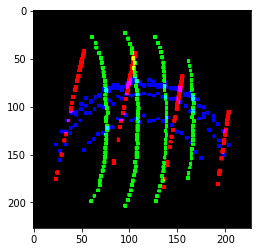

In [37]:
data = next(show_iter)
img = data[0][0].numpy()
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
output = alexnet(x)
print(x.shape)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 227, 227)
torch.Size([1, 3, 227, 227])
[tensor([[401.2282]], device='cuda:0'), tensor([[401.2282]], device='cuda:0'), tensor([[636.4358]], device='cuda:0')]
Prediction:  buoy
Label:  buoy
Image shape:  (227, 227, 3)


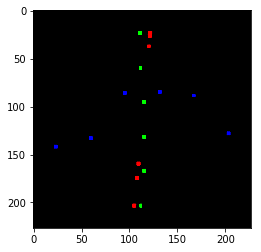

In [95]:
data = next(show_iter)
img = data[0][0].numpy()
print(img.shape)
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
print(x.shape)
scalar_data = [i.cuda() for i in data[2]]
output = multiviewnet(x, scalar_data)
print(scalar_data)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

In [96]:
torch.save(multiviewnet, '../model_scale/robotx_final.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MultiViewNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
